#  План работы

1. Подготовка данных
2. Анализ данных
3. Обучение моделей
4. Тестирование
5. Выводы

## Подготовка

<div style="border:solid blue 2px; padding: 20px">

Импортируем библиотеки
</div>

In [1]:
import pandas as pd
import numpy as np
import time
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
warnings.filterwarnings('ignore')

<div style="border:solid blue 2px; padding: 20px">

Откроем и изучим файл
    
    
</div>

In [2]:
# чтение файла с данными и сохранение
# метод try-except поможет загрузить данные локально или глобально
try:
    data = pd.read_csv('C:/Users/taxi.csv', index_col=[0], parse_dates=[0])  # Локальный путь
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])  # Серверный путь

<div style="border:solid blue 2px; padding: 20px">
    
`head()` выводим на экран первые пять строк таблицы:
    </div>

In [3]:
# получение первых 5 строк таблицы
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<div style="border:solid blue 2px; padding: 20px">
    
`info()` получим общую информацию о таблице:
    </div>

In [4]:
# получение общей информации о данных в таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


<div style="border:solid blue 2px; padding: 20px">
    
 
Методом `describe()` получим описание данных 
    
    
</div> 

In [5]:
# описание данных
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<div style="border:solid blue 2px; padding: 20px">
    
 
Методом `sort_index()` отсортируем индекс таблицы и 
    
    
`is_monotonic()` проверим, в хронологическом ли порядке расположены даты и время
    
    
</div> 

In [6]:
# сортировка индексов
data.sort_index(inplace=True)

In [7]:
# проверка монотонности
data.index.is_monotonic

True

<div style="border:solid blue 2px; padding: 20px">
    
 
Методом `max()` `min()`получим начало и конец даты и время наблюдения
    
    
</div> 

In [8]:
# начальная и конечная даты наблюдений
print('Дата начала наблюдений: {}'.format(data.index.min()))
print('Дата окончания наблюдений: {}'.format(data.index.max()))
print('Временной отрезок: {}'.format(data.index.max() - data.index.min()))

Дата начала наблюдений: 2018-03-01 00:00:00
Дата окончания наблюдений: 2018-08-31 23:50:00
Временной отрезок: 183 days 23:50:00


<div style="border:solid blue 2px; padding: 20px">

### Вывод


    
    
</div>

<div style="border:solid blue 2px; padding: 20px">
    
**Оценка полученных данных**

Наблюдения, представленные в таблице описываются количественными значениями.
    
Дата начала наблюдений: `2018-03-01 00:00:00`
    
Дата окончания наблюдений: `2018-08-31 23:50:00`
    
Временной отрезок: `183 дня 23:50:00`
    
Данные можно исследовать для дальнейшего анализа:
    
`num_orders` - количество заказов - целевой признак
    
Привели данные к удобному формату, для их анализа:
    
аргументом `parse_dates` изменили тип данных `Datetime` с `object` на `datetime64`
    
аргументом `index_col` установили индекс таблицы равным столбцу `Datetime`
    
методом `sort_index` отсортировали индекс таблицы
    
аргументом `is_monotonic` проверили хронологический порядок расположения дат
    
    
</div> 

## Анализ

<div style="border:solid blue 2px; padding: 20px">
    
 
Методом `resample()` поменяем интервал временного ряда с `10мин` на `1 час`
    
и `sum()` вычислим агрегированное значение ряда
    
    
</div> 

In [9]:
# изменение интервала временного ряда
data = data.resample('1H').sum()

<AxesSubplot:title={'center':'График временного ряда интервал 1час'}, xlabel='datetime'>

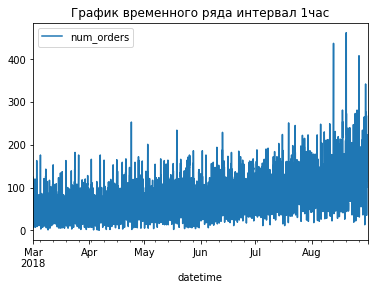

In [10]:
data.plot(title = 'График временного ряда интервал 1час')

<div style="border:solid blue 2px; padding: 20px">
    
 
Временной ряд необходимо разбить на составляющие `trend` `seasonal` `resid`

    
</div> 

<div style="border:solid blue 2px; padding: 20px">
    
 
`seasonal_decompose()` разобъём временной ряд на `trend` `seasonal` `resid`

    
</div> 

In [11]:
decomposed = seasonal_decompose(data['num_orders'])

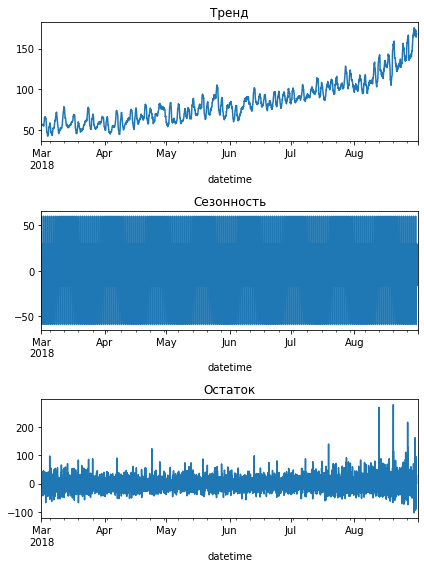

In [12]:
# графики составляющих временной ряд
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

<div style="border:solid blue 2px; padding: 20px">
    
 
`trend` показывает рост во времени
    
`seasonal` исследуем дальше - период месяц и неделя, итервал 1 день
    
`resid` не объяснимы)))

    
</div> 

<div style="border:solid blue 2px; padding: 20px">
    
 
Построим график сезонной составляющей за один месяц

    
</div> 

<AxesSubplot:xlabel='datetime'>

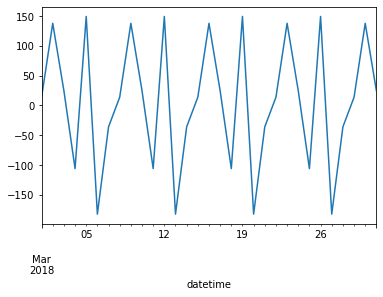

In [13]:
# график сезонности за один месяц с интервалом в 1день
seasonal_decompose(data['num_orders'].resample('1D').sum()).seasonal['2018-03-01':'2018-03-31'].plot()

<div style="border:solid blue 2px; padding: 20px">
    
 
На графике сезонной составляющей за месяц наблюдаем сезонность по неделям


    
</div> 

<div style="border:solid blue 2px; padding: 20px">
    
 
Построим график сезонной составляющей за одну неделю

    
</div> 

<AxesSubplot:xlabel='datetime'>

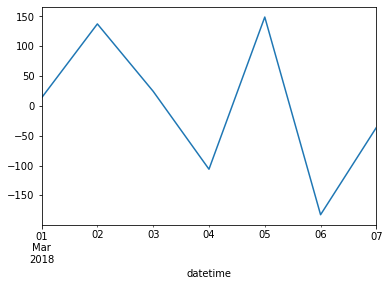

In [14]:
# график сезонности за одну неделю с интервалом в 1день
seasonal_decompose(data['num_orders'].resample('1D').sum()).seasonal['2018-03-01':'2018-03-07'].plot()

<div style="border:solid blue 2px; padding: 20px">
    
 
На графике сезонной составляющей за одну неделю наблюдаем
    
- увеличение количества заказов на 1-2 день и 5-день
    
- снижение количества заказов на 3-4 день и 6-день

    
</div> 

<div style="border:solid blue 2px; padding: 20px">
    
 
`shift()` применим для получения сдвига
    
Сделаем ряд стационарным, найдём разности временного ряда

    
</div> 

In [15]:
# получение разности временного ряда
data = data - data.shift(fill_value=0)

<div style="border:solid blue 2px; padding: 20px">
    
 
`rolling()` применим скользящее среднее и
    
    
`mean()` для агрегации значений
    

`std()` для агрегации значений    
    
</div> 

In [16]:
# получение столбца с размером окна 10
data['rolling_mean'] = data['num_orders'].rolling(7).mean()

In [17]:
# получение столбца с размером окна 10
data['rolling_std'] = data['num_orders'].rolling(7).std()

<AxesSubplot:title={'center':'График Временного ряда/Скользящего среднего/Скользящего стандартного отклонения'}, xlabel='datetime'>

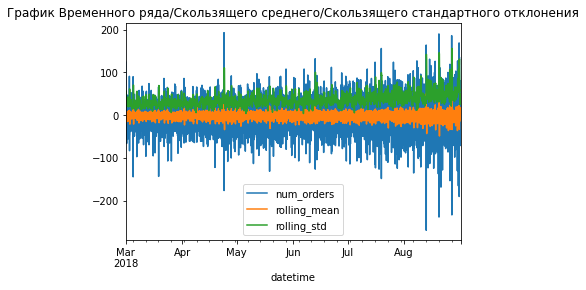

In [18]:
data.plot(title = 'График Временного ряда/Скользящего среднего/Скользящего стандартного отклонения')

<div style="border:solid blue 2px; padding: 20px">
    
 
Временной ряд стал более стационарным

    
</div> 

<div style="border:solid blue 2px; padding: 20px">
    
 
Проведём статистический тест Дики-Фуллера. Сделаем предположения о данных.
    
Он определяет, насколько сильно временной ряд определяется трендом.

    
</div> 

<div style="border:solid blue 2px; padding: 20px">
    
 
**Нулевая гипотеза (H0)**: Временной ряд является нестационарным
    
 
**Альтернативная гипотеза (H1)**: Временной ряд является стационарным

    
</div> 

<div style="border:solid blue 2px; padding: 20px">
    
    
Пороговое значение зададим `alpha` `=`  `0.05`
    

    
</div> 

In [19]:
# проверка гипотезы
alpha = 0.05
result = adfuller(data['num_orders'], regression='ctt')
print('ADF Statistic: %f' % result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if (result[1] < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

ADF Statistic: -15.802772
p-value: 1.8010703814638697e-24
Critical Values:
	1%: -4.374
	5%: -3.834
	10%: -3.554
Отвергаем нулевую гипотезу


<div style="border:solid blue 2px; padding: 20px">
    
    
Тестовое статистическое значение `adf` `-15.8`. 
    
Чем более отрицательна эта статистика, тем больше вероятность того, 
    
что мы отвергнем нулевую гипотезу, т.е. у нас есть стационарный набор данных.
    

    
</div> 

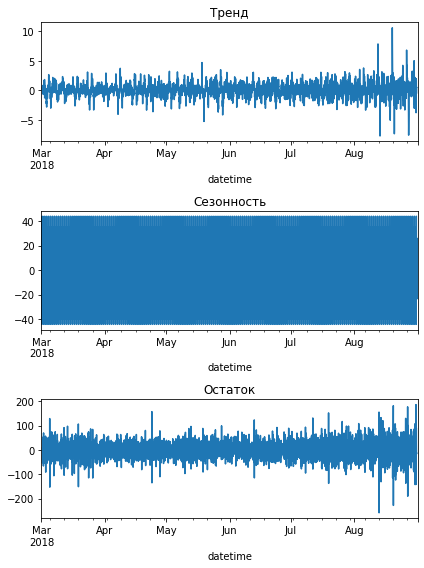

In [20]:
# графики составляющих временной ряд
decomposed = seasonal_decompose(data['num_orders'])
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

<AxesSubplot:xlabel='datetime'>

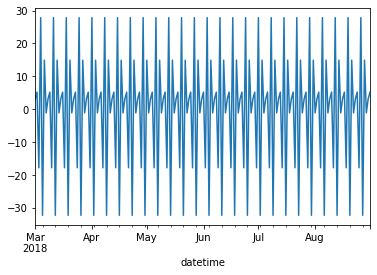

In [21]:
# график сезонности с интервалом в 1день
seasonal_decompose(data['num_orders'].resample('1D').sum()).seasonal.plot()

<div style="border:solid blue 2px; padding: 20px">
    
 
Удалим из данных признаки `rolling_mean` и `rolling_std`
    

    
</div> 

In [22]:
#удаление столбцов
data = data.drop(columns=['rolling_mean','rolling_std'])

<div style="border:solid blue 2px; padding: 20px">
    
Создадим функцию `make_features()` c параметрами `data`, `max_lag`, `rolling_mean_size`
    
    
</div> 

In [23]:
df = data.copy()

In [24]:
# функция получения признаков
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
make_features(data, 15, 35)

<div style="border:solid blue 2px; padding: 20px">

### Вывод


    
    
</div>

<div style="border:solid blue 2px; padding: 20px">
    
Поменяли интервал временного ряда - выполнили его ресемплирование
    
Чтобы лучше понимать временной ряд, разобрали на тренд и сезонность
    
Применили скользящее среднее, чтобы во временном ряду снизить колебания
    
Получили разности временного ряда, чтобы ряд сделать стационарным и проверили статистическим тестом
    
Создали признаки для горизонта прогнозирования в один шаг функцией `make_features`

    
    
</div> 

Learning rate set to 0.062113
0:	learn: 34.1289878	test: 46.6023956	best: 46.6023956 (0)	total: 52ms	remaining: 52s
100:	learn: 22.4127355	test: 36.3535039	best: 36.3535039 (100)	total: 421ms	remaining: 3.74s
200:	learn: 19.5922932	test: 35.2926246	best: 35.2926246 (200)	total: 769ms	remaining: 3.06s
300:	learn: 17.4337753	test: 34.9359241	best: 34.9359241 (300)	total: 1.12s	remaining: 2.59s
400:	learn: 15.8104353	test: 34.5708578	best: 34.5708578 (400)	total: 1.46s	remaining: 2.18s
500:	learn: 14.4762869	test: 34.4496899	best: 34.4458782 (485)	total: 1.84s	remaining: 1.83s
600:	learn: 13.3112049	test: 34.3950725	best: 34.3923539 (598)	total: 2.21s	remaining: 1.47s
700:	learn: 12.1936757	test: 34.3625213	best: 34.3391400 (695)	total: 2.56s	remaining: 1.09s
800:	learn: 11.2743161	test: 34.4096684	best: 34.3391400 (695)	total: 2.92s	remaining: 724ms
900:	learn: 10.4057386	test: 34.3192519	best: 34.3192519 (900)	total: 3.28s	remaining: 360ms
999:	learn: 9.6773198	test: 34.2861180	best: 34

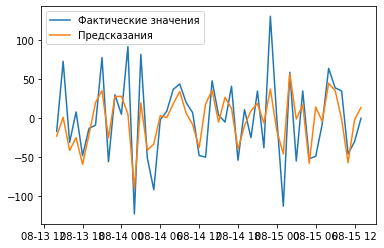

In [25]:
def m_f(df, max_lag, rolling_mean_size):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
   
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

m_f(df, 15, 35)

df_part, df_test = train_test_split(df,test_size=0.1,random_state=42,shuffle=False)
df_part = df_part.dropna()
df_train, df_valid = train_test_split(df_part,test_size=0.1,random_state=42,shuffle=False)
df_features_train = df_train.drop(columns=['num_orders'])
df_target_train = df_train['num_orders']
df_features_part = df_part.drop(columns=['num_orders'])
df_target_part = df_part['num_orders']
df_features_valid = df_valid.drop(columns=['num_orders'])
df_target_valid = df_valid['num_orders']
df_features_test = df_test.drop(columns=['num_orders'])
df_target_test = df_test['num_orders']
split_correct = TimeSeriesSplit(n_splits=8)
par = {'random_state': 42,
          'verbose': 100}
cbr = CatBoostRegressor(**par)
cbr.fit(df_features_train,df_target_train,eval_set=(df_features_valid,df_target_valid))
print(cbr.get_feature_importance(prettified=True))
cbr.fit(df_features_part,df_target_part)
df_pred_cbr_test = cbr.predict(df_features_test) # предсказание модели CatBoostRegressor
rmse_test = mean_squared_error(df_target_test, df_pred_cbr_test)**0.5
print('RMSE модели CatBoostRegressor на тестовой выборке:', rmse_test)
plt.plot(df_features_test[:48].index, df_target_test[:48], label='Фактические значения')
plt.plot(df_features_test[:48].index, df_pred_cbr_test[:48], label='Предсказания')
plt.legend()
plt.show()

## Обучение

<div style="border:solid blue 2px; padding: 20px">
    
 
`train_test_split()` разделим исходные данные на обучающую, валидационную и тестовую выборки
    
    
</div> 

In [26]:
# получение тестовой выборки
data_part, data_test = train_test_split(data,test_size=0.1,random_state=42,shuffle=False)
print('Объектов тестовой выборки', data_test.shape[0])

Объектов тестовой выборки 442


<div style="border:solid blue 2px; padding: 20px">
    
 
`data_part` содержат пропуски. Удалим их `dropna()`
    

    
</div> 

In [27]:
# удаление пропусков
data_part = data_part.dropna()

In [28]:
# получение валидационной и обучающей выборки
data_train, data_valid = train_test_split(data_part,test_size=0.1,random_state=42,shuffle=False)
print('Объектов обучающей выборки', data_train.shape[0])
print('Объектов валидационной выборки', data_valid.shape[0])

Объектов обучающей выборки 3545
Объектов валидационной выборки 394


<div style="border:solid blue 2px; padding: 20px">
    
 
Признаки обучающей, валидационной и тестовой выборки сохраним в отдельных переменных 
    
    
- `features`
    
    
- `target` - целевой признак
    
    
</div> 

In [29]:
# сохранение признаков обучающей выбороки в отдельных переменных
features_train = data_train.drop(columns=['num_orders'])
target_train = data_train['num_orders']

In [30]:
# сохранение признаков  part-выбороки в отдельных переменных
features_part = data_part.drop(columns=['num_orders'])
target_part = data_part['num_orders']

In [31]:
# сохранение признаков валидационной выбороки в отдельных переменных
features_valid = data_valid.drop(columns=['num_orders'])
target_valid = data_valid['num_orders']

In [32]:
# сохранение признаков тестовой выбороки в отдельных переменных
features_test = data_test.drop(columns=['num_orders'])
target_test = data_test['num_orders']

<div style="border:solid blue 2px; padding: 20px">
    
 
`TimeSeriesSplit()` применим чтобы не нарушать порядок следования данных
    
    
</div> 

In [33]:
split = TimeSeriesSplit(n_splits=8)

<div style="border:solid blue 2px; padding: 20px">
    
 
Исследуем качество на модели — решающее дерево.

    
    
</div> 

In [34]:
tree = DecisionTreeRegressor(random_state=42)

In [35]:
parametrs_dtr = {'criterion':['mse'],'max_depth': range(1,10)}

In [36]:
%%time
time_start=time.time()
model_dtr = GridSearchCV(tree, parametrs_dtr,scoring='neg_mean_squared_error', cv=split)
model_dtr.fit(features_train, target_train)
print('Модель', model_dtr.best_estimator_)
print('Оценка', (model_dtr.best_score_ * -1)**0.5)
time_model_dtr=time.time()-time_start
print('Время выполнения ячейки кода:',time_model_dtr)

Модель DecisionTreeRegressor(max_depth=6, random_state=42)
Оценка 28.994199427095506
Время выполнения ячейки кода: 2.3068344593048096
CPU times: user 1.2 s, sys: 0 ns, total: 1.2 s
Wall time: 2.31 s


In [37]:
%%time
time_start=time.time()
predictions_dtr_valid = model_dtr.predict(features_valid) # предсказание модели DecisionTreeRegressor
time_predict_model_dtr=time.time()-time_start
rmse_dtr_valid = mean_squared_error(target_valid, predictions_dtr_valid)**0.5
print('Время выполнения ячейки кода:',time_predict_model_dtr)
print('RMSE модели DecisionTreeRegressor на валидационной выборке:', rmse_dtr_valid)

Время выполнения ячейки кода: 0.0033271312713623047
RMSE модели DecisionTreeRegressor на валидационной выборке: 37.99220578348338
CPU times: user 5.36 ms, sys: 0 ns, total: 5.36 ms
Wall time: 4.24 ms


In [38]:
forest = RandomForestRegressor(random_state=42)

In [39]:
parametrs_rfr = {'n_estimators': range (1,5),'max_depth': range (1,5)}

In [40]:
%%time
time_start=time.time()
model_rfr = GridSearchCV(forest, parametrs_rfr,scoring='neg_mean_squared_error', cv=split)
model_rfr.fit(features_train, target_train)
print('Модель', model_rfr.best_estimator_)
print('Оценка', (model_rfr.best_score_ * -1)**0.5)
time_model_rfr=time.time()-time_start
print('Время выполнения ячейки кода:',time_model_rfr)

Модель RandomForestRegressor(max_depth=4, n_estimators=4, random_state=42)
Оценка 28.8179699742815
Время выполнения ячейки кода: 1.6882755756378174
CPU times: user 1.64 s, sys: 0 ns, total: 1.64 s
Wall time: 1.69 s


In [41]:
%%time
time_start=time.time()
predictions_rfr_valid = model_rfr.predict(features_valid) # предсказание модели RandomForestRegressor
time_predict_model_rfr=time.time()-time_start               
rmse_rfr_valid = mean_squared_error(target_valid, predictions_rfr_valid)**0.5
print('Время выполнения ячейки кода:',time_predict_model_rfr)
print('RMSE модели RandomForestRegressor на валидационной выборке:', rmse_rfr_valid)

Время выполнения ячейки кода: 0.003408193588256836
RMSE модели RandomForestRegressor на валидационной выборке: 40.61500796858984
CPU times: user 5.16 ms, sys: 0 ns, total: 5.16 ms
Wall time: 4.22 ms


<div style="border:solid blue 2px; padding: 20px">
    
 
Исследуем качество на модели — линейная регрессия.

    
    
</div> 

In [42]:
model_lr = LinearRegression()

In [43]:
parametrs_lr = {}

In [44]:
%%time
time_start=time.time()
model_lr = GridSearchCV(model_lr, parametrs_lr,scoring='neg_mean_squared_error', cv=split)
model_lr.fit(features_train,target_train)
print('Модель', model_lr)
print('Оценка', (model_lr.best_score_ * -1)**0.5)
time_model_lr=time.time()-time_start
print('Время выполнения ячейки кода:',time_model_lr)

Модель GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=LinearRegression(), param_grid={},
             scoring='neg_mean_squared_error')
Оценка 30.213063670441535
Время выполнения ячейки кода: 0.13396549224853516
CPU times: user 107 ms, sys: 90.4 ms, total: 198 ms
Wall time: 134 ms


In [45]:
%%time
time_start=time.time()
predictions_lr_valid = model_lr.predict(features_valid) # предсказание модели LinearRegression
time_predict_model_lr=time.time()-time_start
rmse_lr_valid = mean_squared_error(target_valid, predictions_lr_valid)**0.5
print('Время выполнения ячейки кода:',time_predict_model_lr)
print('RMSE модели LinearRegression на валидационной выборке:', rmse_lr_valid)

Время выполнения ячейки кода: 0.002033710479736328
RMSE модели LinearRegression на валидационной выборке: 41.045467626131
CPU times: user 8.19 ms, sys: 12 ms, total: 20.2 ms
Wall time: 3.85 ms


<div style="border:solid blue 2px; padding: 20px">
    
 
Исследуем качество на модели — бустинг для категориальных признаков.

    
    
</div> 

In [46]:
params_crb = {'random_state': 42,
          'verbose': 100}

In [47]:
model_cbr = CatBoostRegressor(**params_crb)

In [48]:
%%time
time_start=time.time()
model_cbr.fit(features_train,target_train,eval_set=(features_valid,target_valid))
time_model_cbr=time.time()-time_start
print('Время выполнения ячейки кода:',time_model_cbr)

Learning rate set to 0.062113
0:	learn: 34.1289878	test: 46.6023956	best: 46.6023956 (0)	total: 4.17ms	remaining: 4.16s
100:	learn: 22.4127355	test: 36.3535039	best: 36.3535039 (100)	total: 371ms	remaining: 3.3s
200:	learn: 19.5922932	test: 35.2926246	best: 35.2926246 (200)	total: 725ms	remaining: 2.88s
300:	learn: 17.4337753	test: 34.9359241	best: 34.9359241 (300)	total: 1.08s	remaining: 2.5s
400:	learn: 15.8104353	test: 34.5708578	best: 34.5708578 (400)	total: 1.44s	remaining: 2.15s
500:	learn: 14.4762869	test: 34.4496899	best: 34.4458782 (485)	total: 1.79s	remaining: 1.79s
600:	learn: 13.3112049	test: 34.3950725	best: 34.3923539 (598)	total: 2.15s	remaining: 1.43s
700:	learn: 12.1936757	test: 34.3625213	best: 34.3391400 (695)	total: 2.52s	remaining: 1.08s
800:	learn: 11.2743161	test: 34.4096684	best: 34.3391400 (695)	total: 2.9s	remaining: 721ms
900:	learn: 10.4057386	test: 34.3192519	best: 34.3192519 (900)	total: 3.27s	remaining: 359ms
999:	learn: 9.6773198	test: 34.2861180	best: 3

In [49]:
model_cbr.get_feature_importance(prettified=True)

,Feature Id,Importances
0,hour,27.284182
1,rolling_mean,13.087765
2,lag_1,11.290618
3,lag_2,5.198798
4,lag_8,4.536298
5,lag_15,3.923267
6,lag_3,3.619736
7,lag_4,3.595290
8,lag_12,3.201816
9,lag_11,3.147020


<div style="border:solid blue 2px; padding: 20px">
    
 
Исследуем качество на модели — лёгкая машина градиентного бустинга.

    
    
</div> 

In [50]:
params_lgbm = {'metric': 'rmse',
          'random_state': 42,
          'verbose': 100}

In [51]:
model_lgbm = LGBMRegressor(**params_lgbm)

In [52]:
%%time
time_start=time.time()
model_lgbm.fit(features_train,target_train, eval_set=[(features_valid, target_valid)])
time_model_lgbm=time.time()-time_start
print('Время выполнения ячейки кода:',time_model_lgbm)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.021282
[LightGBM] [Debug] init for col-wise cost 0.000009 seconds, init for row-wise cost 0.000603 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 2890
[LightGBM] [Info] Number of data points in the train set: 3545, number of used features: 18
[LightGBM] [Info] Start training from score 0.022003
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[1]	valid_0's rmse: 45.6736
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[2]	valid_0's rmse: 44.2425
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[3]	valid_0's rmse: 43.0748
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[4]	valid_0's rmse: 42.058

<div style="border:solid blue 2px; padding: 20px">

### Вывод


    
    
</div> 

<div style="border:solid blue 2px; padding: 20px">
    
 
`RSME` для моделей на валидации
    
    
    
- `DecisionTreeRegressor` - `37.992`
    
    
- `RandomForestRegressor` - `40.615`
    
    
- `LinearRegression` - `41.045` 
    
    
- `CatBoostRegressor` - `34.275`
    
    
- `LGBMRegressor` - `35.102`

    
    
</div> 

## Тестирование

<div style="border:solid blue 2px; padding: 20px">
    
 
Проверим качество на тестовой выборке модели — решающее дерево.

    
    
</div> 

In [53]:
%%time
time_start=time.time()
model_dtr = GridSearchCV(tree, parametrs_dtr,scoring='neg_mean_squared_error', cv=split)
model_dtr.fit(features_part, target_part)
print('Модель', model_dtr.best_estimator_)
print('Оценка', (model_dtr.best_score_ * -1)**0.5)
time_model_dtr=time.time()-time_start
print('Время выполнения ячейки кода:',time_model_dtr)

Модель DecisionTreeRegressor(max_depth=5, random_state=42)
Оценка 30.662174840338192
Время выполнения ячейки кода: 0.961280345916748
CPU times: user 895 ms, sys: 4.25 ms, total: 899 ms
Wall time: 962 ms


In [54]:
%%time
time_start=time.time()
predictions_dtr_test = model_dtr.predict(features_test) # предсказание модели DecisionTreeRegressor
time_predict_model_dtr_test=time.time()-time_start
rmse_dtr_test = mean_squared_error(target_test, predictions_dtr_test)**0.5
print('Время выполнения ячейки кода:',time_predict_model_dtr_test)
print('RMSE модели DecisionTreeRegressor на тестовой выборке:', rmse_dtr_test)

Время выполнения ячейки кода: 0.0020096302032470703
RMSE модели DecisionTreeRegressor на тестовой выборке: 51.38624326768079
CPU times: user 3.38 ms, sys: 0 ns, total: 3.38 ms
Wall time: 2.67 ms


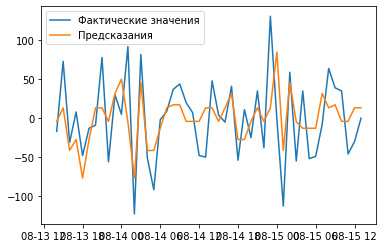

In [55]:
plt.plot(features_test[:48].index, target_test[:48], label='Фактические значения')
plt.plot(features_test[:48].index, predictions_dtr_test[:48], label='Предсказания')
plt.legend()
plt.show()

<div style="border:solid blue 2px; padding: 20px">
    
 
Проверим качество на тестовой выборке модели — случайный лес.
    

    
</div> 

In [56]:
%%time
time_start=time.time()
model_rfr = GridSearchCV(forest, parametrs_rfr,scoring='neg_mean_squared_error', cv=split)
model_rfr.fit(features_part, target_part)
print('Модель', model_rfr.best_estimator_)
print('Оценка', (model_rfr.best_score_ * -1)**0.5)
time_model_rfr=time.time()-time_start
print('Время выполнения ячейки кода:',time_model_rfr)

Модель RandomForestRegressor(max_depth=4, n_estimators=4, random_state=42)
Оценка 30.550725242546612
Время выполнения ячейки кода: 1.7528691291809082
CPU times: user 1.74 s, sys: 4.17 ms, total: 1.74 s
Wall time: 1.75 s


In [57]:
%%time
time_start=time.time()
predictions_rfr_test = model_rfr.predict(features_test) # предсказание модели RandomForestRegressor
time_predict_model_rfr_test=time.time()-time_start               
rmse_rfr_test = mean_squared_error(target_test, predictions_rfr_test)**0.5
print('Время выполнения ячейки кода:',time_predict_model_rfr_test)
print('RMSE модели RandomForestRegressor на тестовой выборке:', rmse_rfr_test)

Время выполнения ячейки кода: 0.0032258033752441406
RMSE модели RandomForestRegressor на тестовой выборке: 49.91106949649767
CPU times: user 4.73 ms, sys: 58 µs, total: 4.79 ms
Wall time: 4.04 ms


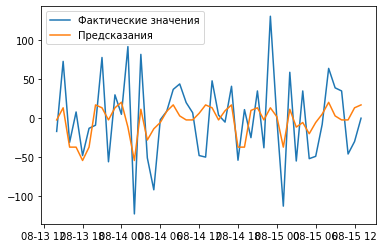

In [58]:
plt.plot(features_test[:48].index, target_test[:48], label='Фактические значения')
plt.plot(features_test[:48].index, predictions_rfr_test[:48], label='Предсказания')
plt.legend()
plt.show()

<div style="border:solid blue 2px; padding: 20px">
    
 
Проверим качество на тестовой выборке модели — линейная регрессия.

    
    
</div> 

In [59]:
%%time
time_start=time.time()
model_lr = GridSearchCV(model_lr, parametrs_lr,scoring='neg_mean_squared_error', cv=split)
model_lr.fit(features_part,target_part)
print('Модель', model_lr)
print('Оценка', (model_lr.best_score_ * -1)**0.5)
time_model_lr=time.time()-time_start
print('Время выполнения ячейки кода:',time_model_lr)

Модель GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
                                    estimator=LinearRegression(), param_grid={},
                                    scoring='neg_mean_squared_error'),
             param_grid={}, scoring='neg_mean_squared_error')
Оценка 31.74493266489281
Время выполнения ячейки кода: 2.357266664505005
CPU times: user 1.34 s, sys: 1.08 s, total: 2.43 s
Wall time: 2.36 s


In [60]:
%%time
time_start=time.time()
predictions_lr_test = model_lr.predict(features_test) # предсказание модели LinearRegression
time_predict_model_lr_test=time.time()-time_start
rmse_lr_test = mean_squared_error(target_test, predictions_lr_test)**0.5
print('Время выполнения ячейки кода:',time_predict_model_lr_test)
print('RMSE модели LinearRegression на тестовой выборке:', rmse_lr_test)

Время выполнения ячейки кода: 0.005962848663330078
RMSE модели LinearRegression на тестовой выборке: 51.32906182752819
CPU times: user 13.2 ms, sys: 19.7 ms, total: 33 ms
Wall time: 6.74 ms


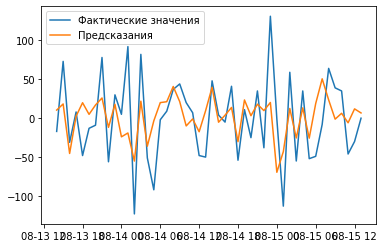

In [61]:
plt.plot(features_test[:48].index, target_test[:48], label='Фактические значения')
plt.plot(features_test[:48].index, predictions_lr_test[:48], label='Предсказания')
plt.legend()
plt.show()

<div style="border:solid blue 2px; padding: 20px">
    
 
Проверим качество на тестовой выборке модели — бустинг для категориальных признаков.

    
    
</div> 

In [62]:
%%time
time_start=time.time()
model_cbr.fit(features_part,target_part)
time_model_cbr=time.time()-time_start
print('Время выполнения ячейки кода:',time_model_cbr)

Learning rate set to 0.050845
0:	learn: 35.6893151	total: 4.05ms	remaining: 4.05s
100:	learn: 24.4804900	total: 413ms	remaining: 3.67s
200:	learn: 21.7715342	total: 779ms	remaining: 3.1s
300:	learn: 19.7601555	total: 1.15s	remaining: 2.67s
400:	learn: 18.1408106	total: 1.53s	remaining: 2.28s
500:	learn: 16.8741093	total: 1.91s	remaining: 1.9s
600:	learn: 15.7169365	total: 2.34s	remaining: 1.55s
700:	learn: 14.7081440	total: 2.74s	remaining: 1.17s
800:	learn: 13.8074132	total: 3.15s	remaining: 783ms
900:	learn: 13.0297247	total: 3.55s	remaining: 390ms
999:	learn: 12.2650935	total: 3.92s	remaining: 0us
Время выполнения ячейки кода: 7.295276165008545
CPU times: user 3.98 s, sys: 91.5 ms, total: 4.07 s
Wall time: 7.3 s


In [63]:
%%time
time_start=time.time()
predictions_cbr_test = model_cbr.predict(features_test) # предсказание модели CatBoostRegressor
time_predict_model_cbr_test=time.time()-time_start
rmse_cbr_test = mean_squared_error(target_test, predictions_cbr_test)**0.5
print('Время выполнения ячейки кода:',time_predict_model_cbr_test)
print('RMSE модели CatBoostRegressor на тестовой выборке:', rmse_cbr_test)

Время выполнения ячейки кода: 0.0028166770935058594
RMSE модели CatBoostRegressor на тестовой выборке: 42.84879832746725
CPU times: user 3.07 ms, sys: 1.96 ms, total: 5.03 ms
Wall time: 3.68 ms


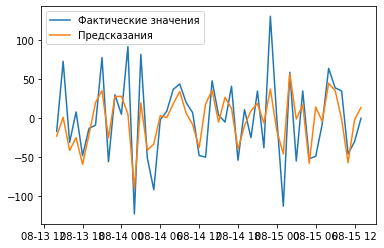

In [64]:
plt.plot(features_test[:48].index, target_test[:48], label='Фактические значения')
plt.plot(features_test[:48].index, predictions_cbr_test[:48], label='Предсказания')
plt.legend()
plt.show()

<div style="border:solid blue 2px; padding: 20px">
    
 
Проверим качество на тестовой выборке модели — лёгкая машина градиентного бустинга.

    
    
</div> 

In [65]:
%%time
time_start=time.time()
model_lgbm.fit(features_part,target_part)
time_model_lgbm=time.time()-time_start
print('Время выполнения ячейки кода:',time_model_lgbm)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.021353
[LightGBM] [Debug] init for col-wise cost 0.000007 seconds, init for row-wise cost 0.000467 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3055
[LightGBM] [Info] Number of data points in the train set: 3939, number of used features: 18
[LightGBM] [Info] Start training from score 0.016502
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Train

In [66]:
%%time
time_start=time.time()
predictions_lgbm_test = model_lgbm.predict(features_test) # предсказание модели LGBMRegressor
time_predict_model_lgbm_test=time.time()-time_start
rmse_lgbm_test = mean_squared_error(target_test, predictions_lgbm_test)**0.5
print('Время выполнения ячейки кода:',time_predict_model_lgbm_test)
print('RMSE модели LGBMRegressor на тестовой выборке:', rmse_lgbm_test)

Время выполнения ячейки кода: 0.08761072158813477
RMSE модели LGBMRegressor на тестовой выборке: 44.9350210512157
CPU times: user 21.9 ms, sys: 1.01 ms, total: 22.9 ms
Wall time: 88.7 ms


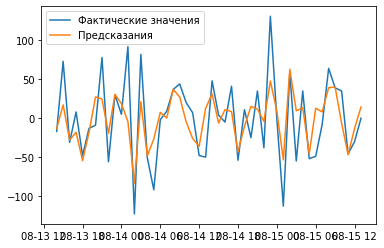

In [67]:
plt.plot(features_test[:48].index, target_test[:48], label='Фактические значения')
plt.plot(features_test[:48].index, predictions_lgbm_test[:48], label='Предсказания')
plt.legend()
plt.show()

<div style="border:solid blue 2px; padding: 20px">

### Вывод


    
    
</div> 

In [68]:
# таблица времени обучения моделей
d = {'model': ['DecisionTreeRegressor','RandomForestRegressor','LinearRegression','CatBoostRegressor','LGBMRegressor'],
     'time_model_fit': [time_model_dtr,time_model_rfr,time_model_lr,time_model_cbr,time_model_lgbm],
     'time_model_predict': [time_predict_model_dtr_test,time_predict_model_rfr_test,time_predict_model_lr_test,time_predict_model_cbr_test,time_predict_model_lgbm_test],
     'rmse_model': [rmse_dtr_test,rmse_rfr_test,rmse_lr_test,rmse_cbr_test,rmse_lgbm_test]
    }
df = pd.DataFrame(data=d)
df.sort_values(by='rmse_model')

,model,time_model_fit,time_model_predict,rmse_model
3,CatBoostRegressor,7.295276,0.002817,42.848798
4,LGBMRegressor,1.295226,0.087611,44.935021
1,RandomForestRegressor,1.752869,0.003226,49.911069
2,LinearRegression,2.357267,0.005963,51.329062
0,DecisionTreeRegressor,0.961280,0.002010,51.386243


<div style="border:solid blue 2px; padding: 20px">
    
Компания «Чётенькое такси», чтобы привлекать больше водителей в период пиковой нагрузки,
    
может применять модель `CatBoostRegressor`, которая показала
    
- время предсказания `time_model_predict` `0.002817`
    
-  качество предсказания `rmse_model` `42.848`, что является минимальным требованием,
    
которое было выполнено по заданию на исследование исторических данных о заказах такси в аэропортах:
    
`Значение метрики RMSE на тестовой выборке должно быть не больше 48`

    
    
</div> 